# HR Analytics: Job Change of Data Scientists
***
**このノートブックの目的**  
cuMLによる分析の概観をつかむ  
  
  
**分析の目的**  
ある企業のデータサイエンティストになるためのトレーニングコースを受講した人が、その企業に転職するかどうか予測する  
  
**データ情報**  
- カラム  
ID、city ID、city development index（居住地の発展度合い）、性別、関連した職歴の有無、学歴、専攻、社会人経験（年）、
現所属企業の大きさ（従業員数）、現所属企業の種別、前職を辞めてからの年数、トレーニングコースの受講時間

- データ件数：19158件
  

**分析の流れ**
 1. データの概要把握
 1. データの可視化
 1. データの前処理
 1. モデルの学習＋ハイパーパラメータ最適化①
 1. インバランスデータへの対処
 1. モデルの学習＋ハイパーパラメータ最適化②
 1. テストデータでの予測
 
 
 **Appendix**  
 Scikit-Learnによる同様の分析とcudfとscikit-learnの実行時間比較

**データリンク**  
下記のリンクよりデータをダウンロードし、zipファイルを解凍してください
- [train data](https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists)
- [test answer](https://www.kaggle.com/arashnic/job-change-dataset-answer)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cudf
import optuna
plt.style.use("ggplot")

In [2]:
def plot_count(x_num:int,y_num:int,figsize:tuple,data:pd.DataFrame,cols:list,hue=None):
    """カウントプロット作成用関数

    Args:
        x_num (int): subplotsのx軸方向の数
        y_num (int): subplotsのy軸方向の数
        figsize (tuple): figureのサイズ
        data (pd.DataFrame): データ
        cols (list): プロットしたい列
        hue (str):層化する列
    """    
    fig, ax = plt.subplots(y_num,x_num, figsize=figsize,tight_layout=True)
    ax = ax.flatten()
    for idx, col in enumerate(cols):
        sns.countplot(x=col,data=data,ax=ax[idx],hue=hue)
        sns.despine()

### **1. データの概要把握**
データをロード

In [3]:
df_train = pd.read_csv("../../../input/training/304/aug_train.csv")
df_test = pd.read_csv("../../../input/testing/305/aug_test.csv")
test_target = np.load("../../../input/testing/306/jobchange_test_target_values.npy")
df_test["target"] = test_target
df_X = df_train.drop(["enrollee_id","target"],axis=1)
df_y = df_train["target"]
numerical_cols = df_X.select_dtypes(exclude="object").columns
categorical_cols = df_X.select_dtypes(include="object").columns
df_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [4]:
df_train.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [5]:
numerical_cols

Index(['city_development_index', 'training_hours'], dtype='object')

In [6]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  19158 non-null  float64
 2   gender                  14650 non-null  object 
 3   relevent_experience     19158 non-null  object 
 4   enrolled_university     18772 non-null  object 
 5   education_level         18698 non-null  object 
 6   major_discipline        16345 non-null  object 
 7   experience              19093 non-null  object 
 8   company_size            13220 non-null  object 
 9   company_type            13018 non-null  object 
 10  last_new_job            18735 non-null  object 
 11  training_hours          19158 non-null  int64  
dtypes: float64(1), int64(1), object(10)
memory usage: 1.8+ MB


欠損値を確認

In [7]:
df_X.isnull().sum()/len(df_X)

city                      0.000000
city_development_index    0.000000
gender                    0.235306
relevent_experience       0.000000
enrolled_university       0.020148
education_level           0.024011
major_discipline          0.146832
experience                0.003393
company_size              0.309949
company_type              0.320493
last_new_job              0.022080
training_hours            0.000000
dtype: float64

### **2. データの可視化**
可視化用ライブラリseabornと併用するため、まずはcudfではなくpandasのdataframeで進める  
カテゴリデータの分布を確認

In [8]:
df_X_prep = df_X.copy()

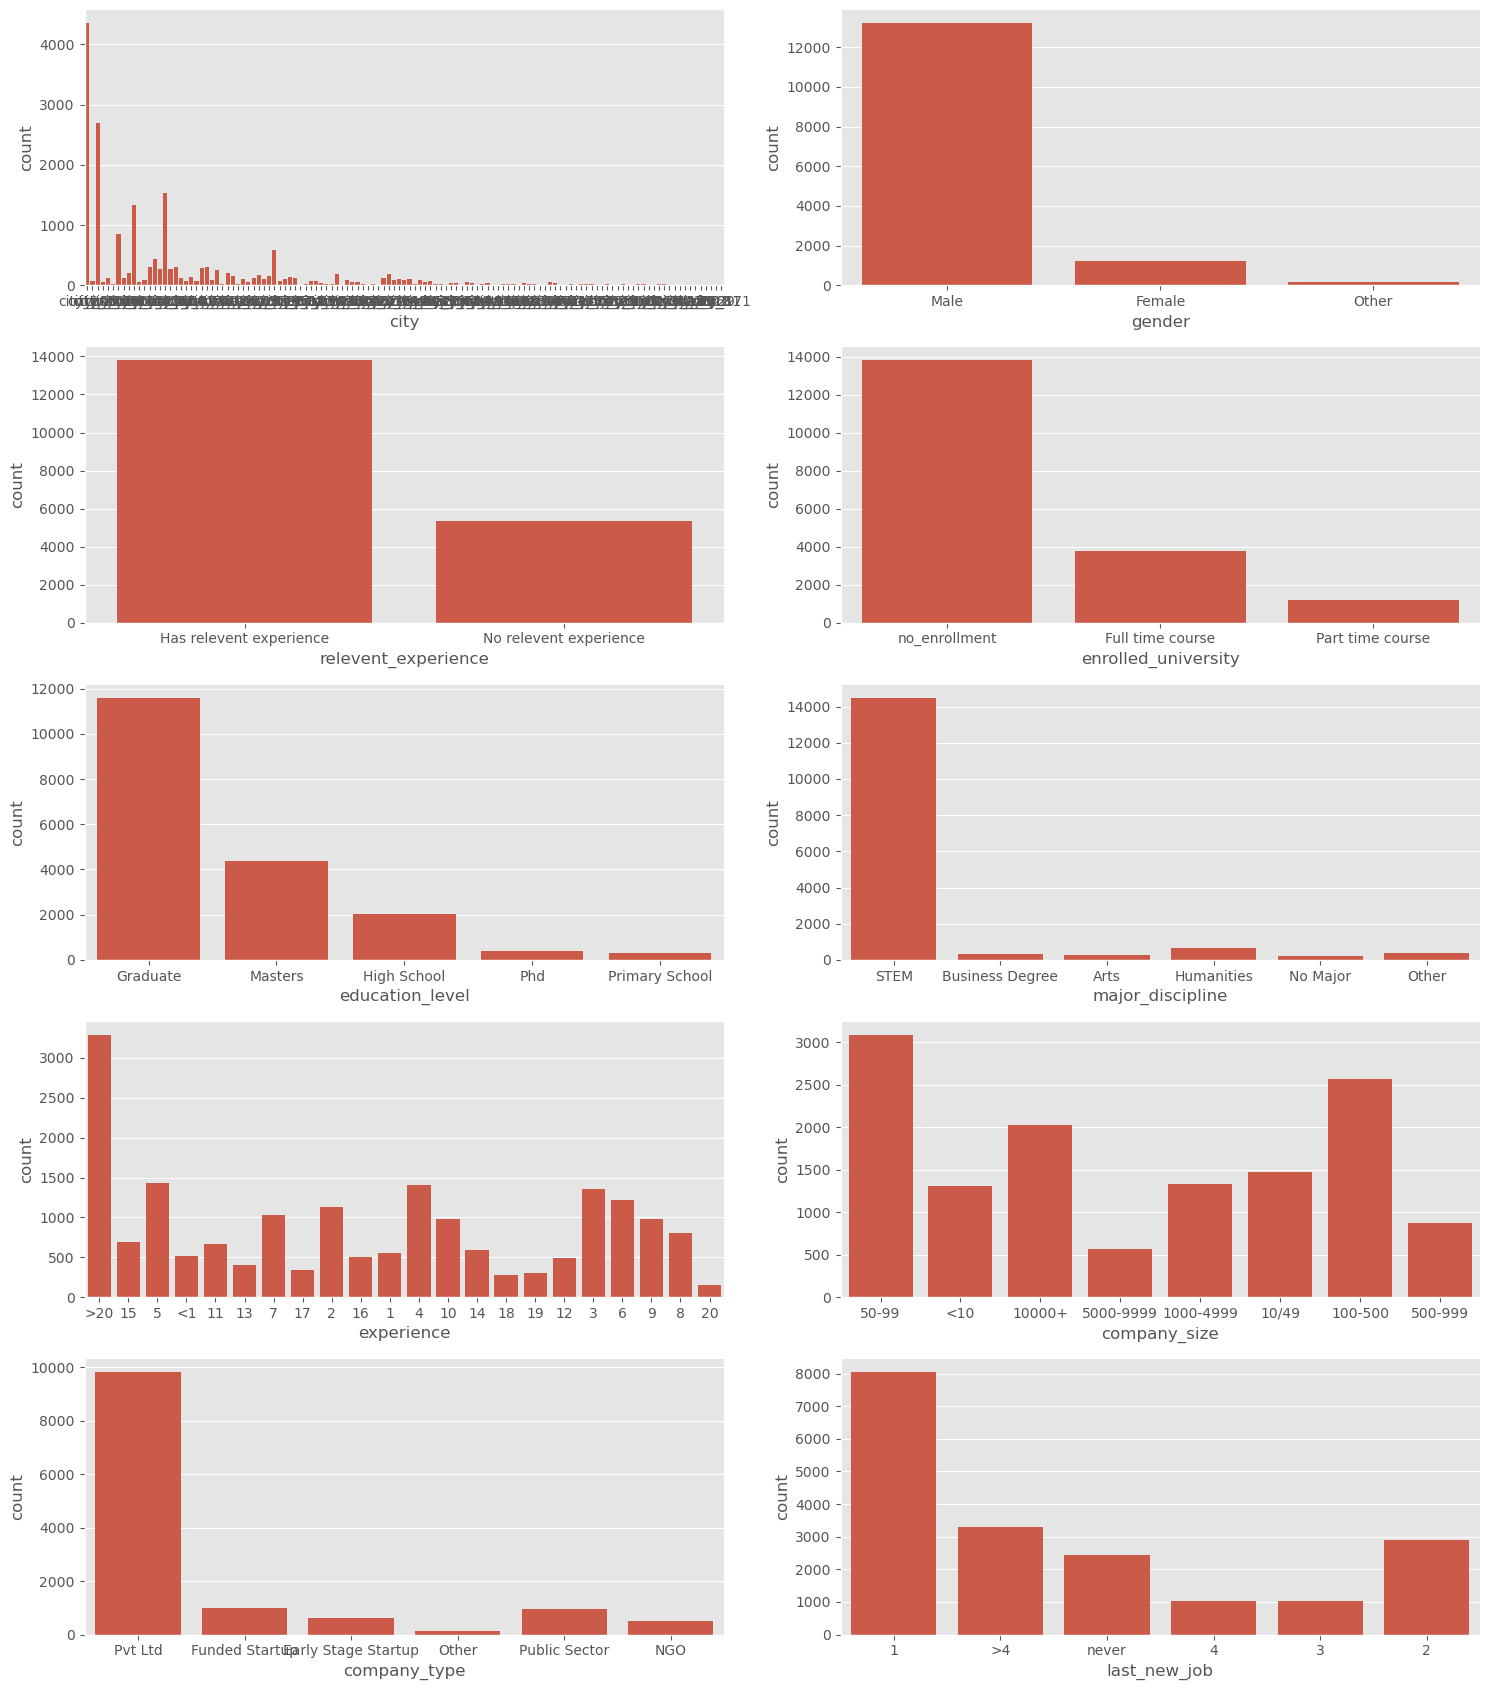

In [9]:
#カテゴリデータのヒストグラムをプロットする
plot_count(2,5,(15,17),df_X_prep,categorical_cols)

目的変数の分布を確認

<AxesSubplot:xlabel='target', ylabel='count'>

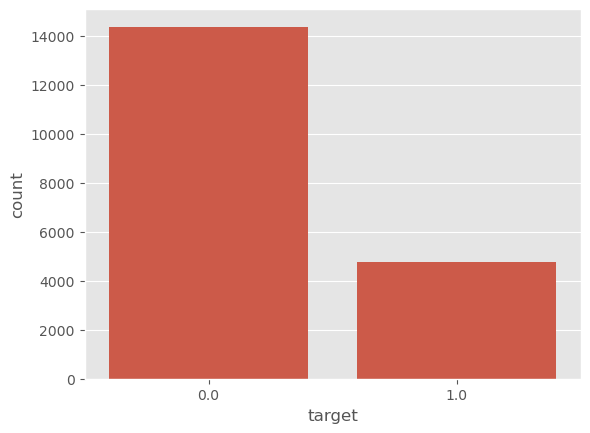

In [10]:
sns.countplot(x=df_y)

0(転職しない)に偏っている。データがインバランス  
  
カテゴリデータで数字に置き換えられそうなカラムを置き換える。目的変数で層化して確認

In [11]:
#カテゴリ変数を数値に置換する
#仕事経験年数">20"→25
#仕事経験年数"<1"→0
df_X_prep.loc[df_X_prep["experience"]==">20","experience"] = 25
df_X_prep.loc[df_X_prep["experience"]=="<1","experience"] = 0
df_X_prep["experience"] = np.array(df_X_prep["experience"].values, dtype=np.float32)
#カテゴリ変数（企業サイズ）の中の不要などを取り除き、数値にする
df_X_prep.loc[(df_X_prep["company_size"].str.contains("-"))&(df_X_prep["company_size"].isnull()==False),"company_size"] = [np.array(x, np.float32).mean() for x in df_X_prep.loc[(df_X_prep["company_size"].str.contains("-"))&(df_X_prep["company_size"].isnull()==False),"company_size"].str.split("-")]
df_X_prep.loc[(df_X_prep["company_size"].str.contains("/"))&(df_X_prep["company_size"].isnull()==False),"company_size"] = [np.array(x, np.float32).mean() for x in df_X_prep.loc[(df_X_prep["company_size"].str.contains("/"))&(df_X_prep["company_size"].isnull()==False),"company_size"].str.split("/")]
#企業サイズ"<10"→10
#企業サイズ"10000+"→10000
df_X_prep.loc[df_X_prep["company_size"]=="<10","company_size"] = 10
df_X_prep.loc[df_X_prep["company_size"]=="10000+","company_size"] = 10000
df_X_prep["company_size"] = np.array(df_X_prep["company_size"].values, dtype=np.float32)

#前職を辞めてからの年数">4"→5
#前職を辞めてからの年数never→0
df_X_prep.loc[df_X_prep["last_new_job"]==">4","last_new_job"] = 5
df_X_prep.loc[df_X_prep["last_new_job"]=="never","last_new_job"] = 0
df_X_prep["last_new_job"] = np.array(df_X_prep["last_new_job"].values, dtype=np.float32)

#連続変数とカテゴリ変数を取得
numerical_cols = df_X_prep.select_dtypes(exclude="object").columns
categorical_cols = df_X_prep.select_dtypes(include="object").columns

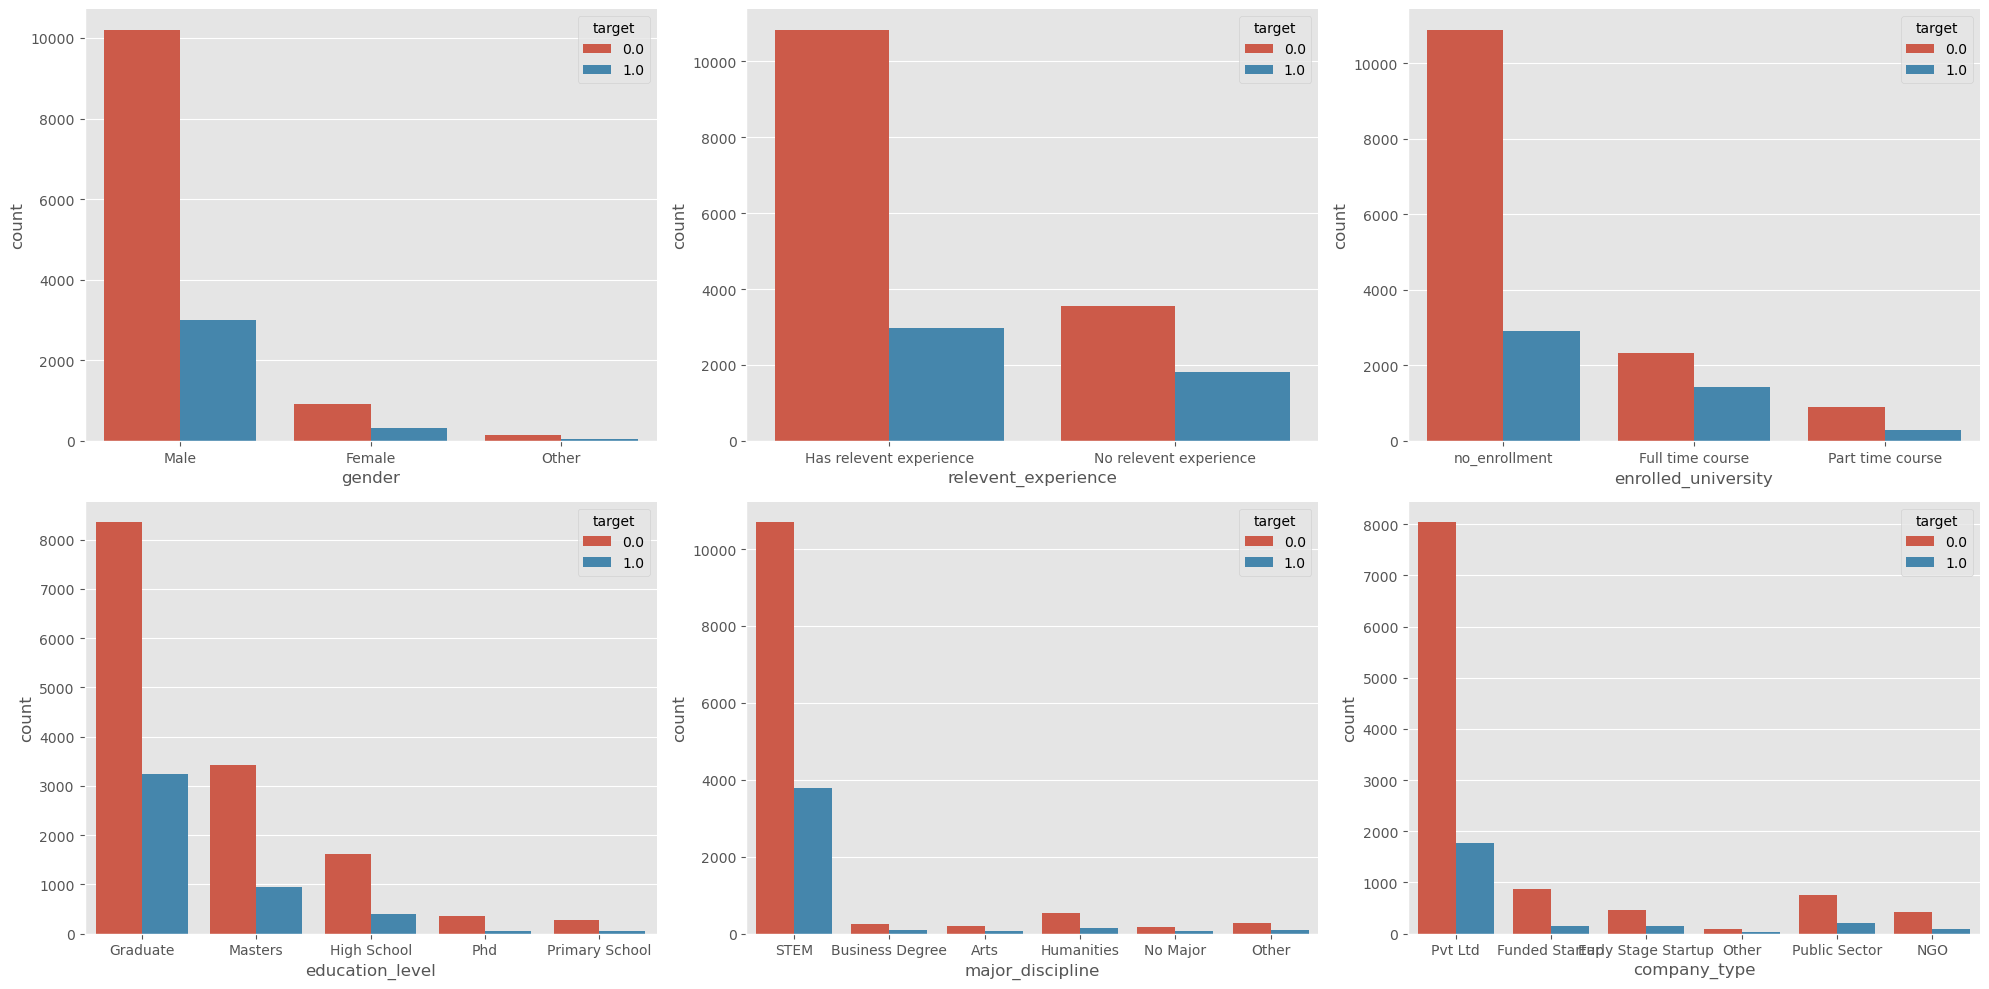

In [12]:
#目的変数で層化して分布を確認
plot_cols = [i for i in categorical_cols if i !="city"]
plot_count(3,2,(20,10),df_X_prep,plot_cols,df_y)

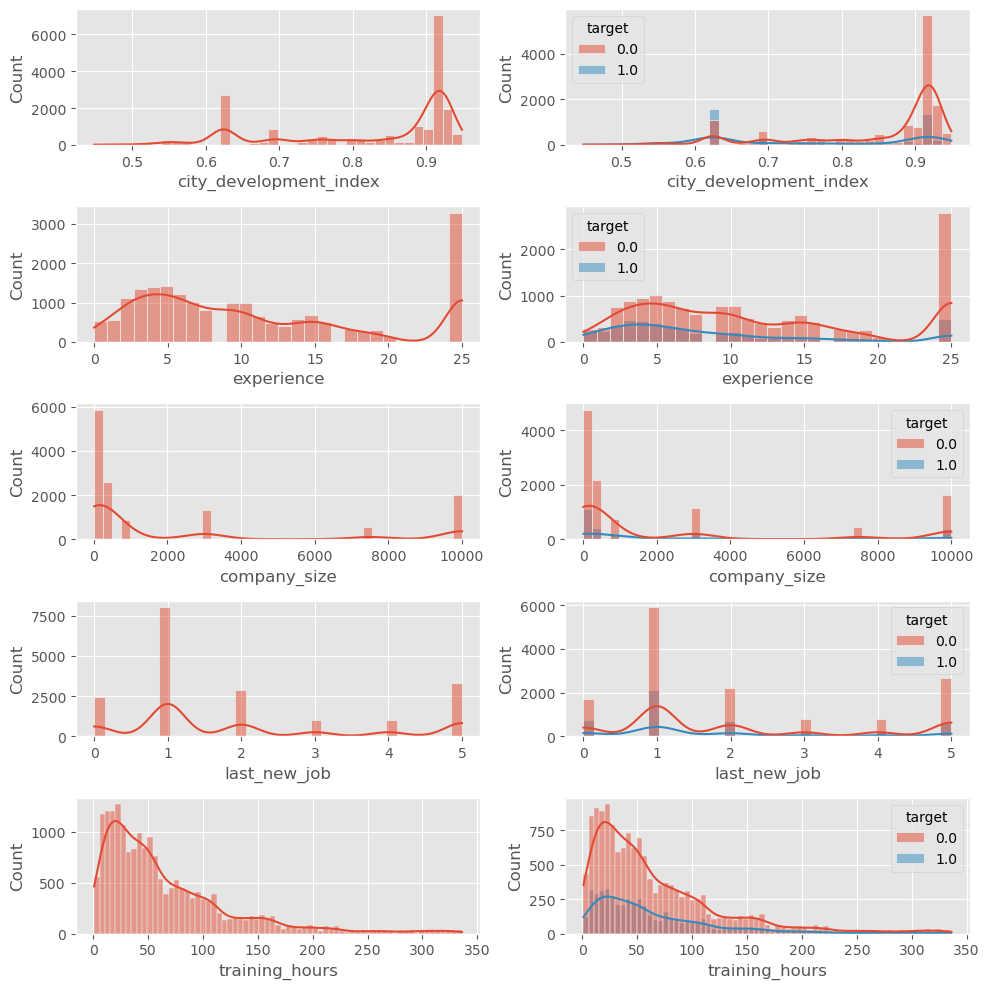

In [13]:
#目的変数で連続変数を層化して分布を確認
fig, ax = plt.subplots(5,2,figsize=(10,10),tight_layout=True)
ax = ax.flatten()
idx = 0
for col in numerical_cols:
    sns.histplot(x=col,data=df_X_prep,kde=True,ax=ax[idx])
    sns.histplot(x=col,data=df_X_prep,kde=True,hue=df_y,ax=ax[idx+1])
    idx += 2

- city development indexが低い町に住んでいる人のほうが転職しやすい
- 経験が浅いほうが転職しやすい
- 会社が小さい人の方が転職しやすい
- 訓練時間が短い人の方が転職しやすい？

<AxesSubplot:xlabel='training_hours', ylabel='Count'>

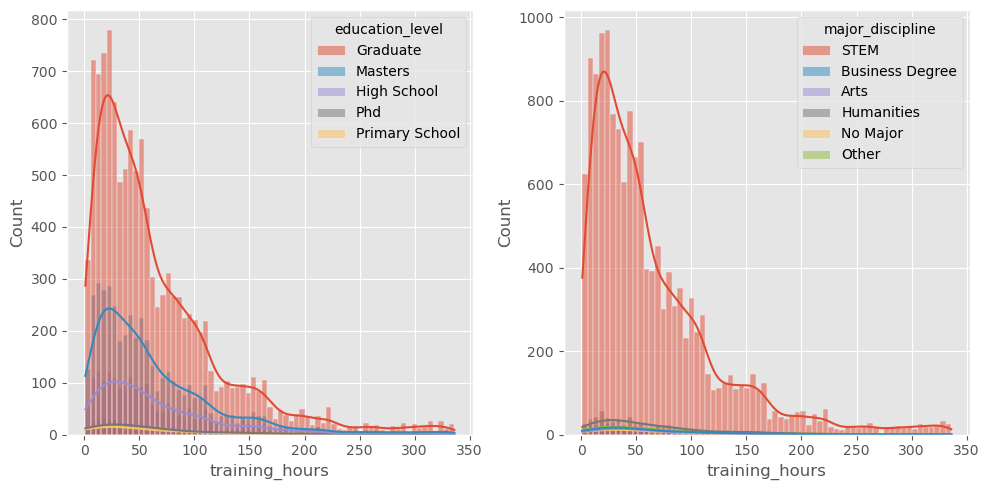

In [14]:
#学歴と専攻でトレーニング受講時間を層化して確認
fig, ax = plt.subplots(1,2,figsize=(10,5),tight_layout=True)
ax = ax.flatten()
sns.histplot(x="training_hours",hue="education_level",data=df_X_prep,kde=True,ax=ax[0])
sns.histplot(x="training_hours",hue="major_discipline",data=df_X_prep,kde=True,ax=ax[1])

<AxesSubplot:xlabel='company_size', ylabel='count'>

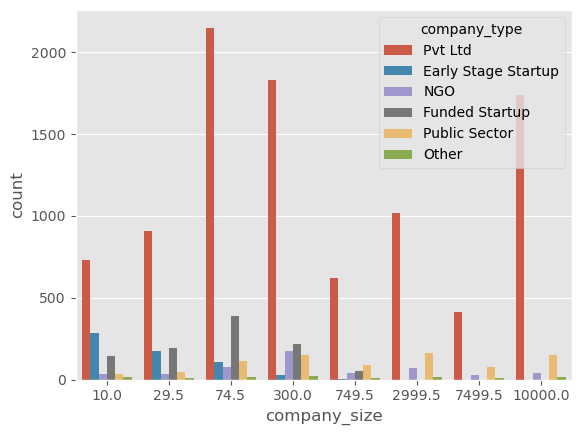

In [15]:
#企業サイズと企業タイプの関連を確認
sns.countplot(x="company_size",data=df_X_prep, hue="company_type")

### **3. データの前処理**

In [16]:
from sklearn.preprocessing import StandardScaler

class preprocessing:
    def __init__(self):
        """
        前処理用クラス
        """
        self.std = StandardScaler()
        self.numerical_cols = None
        self.categorical_cols = None
        
    def fit(self,dataframe,train=True):
        
        #不要な変数("city","enrollee_id")を削除
        dataframe = dataframe.drop(["city","enrollee_id"],axis=1)
        
        #カテゴリ変数を数値に置換する
        #仕事経験年数">20"→25
        #仕事経験年数"<1"→0
        dataframe.loc[dataframe["experience"]==">20","experience"] = 25
        dataframe.loc[dataframe["experience"]=="<1","experience"] = 0
        dataframe["experience"] = np.array(dataframe["experience"].values, dtype=np.float32)

        #カテゴリ変数（企業サイズ）の中の不要などを取り除き、数値にする
        dataframe.loc[(dataframe["company_size"].str.contains("-"))&(dataframe["company_size"].isnull()==False),"company_size"] = [np.array(x, np.float32).mean() for x in dataframe.loc[(dataframe["company_size"].str.contains("-"))&(dataframe["company_size"].isnull()==False),"company_size"].str.split("-")]
        dataframe.loc[(dataframe["company_size"].str.contains("/"))&(dataframe["company_size"].isnull()==False),"company_size"] = [np.array(x, np.float32).mean() for x in dataframe.loc[(dataframe["company_size"].str.contains("/"))&(dataframe["company_size"].isnull()==False),"company_size"].str.split("/")]
        #企業サイズ"<10"→10
        #企業サイズ"10000+"→10000
        dataframe.loc[dataframe["company_size"]=="<10","company_size"] = 10
        dataframe.loc[dataframe["company_size"]=="10000+","company_size"] = 10000
        dataframe["company_size"] = np.array(dataframe["company_size"].values, dtype=np.float32)
        
        #前職を辞めてからの年数">4"→5
        #前職を辞めてからの年数never→0
        dataframe.loc[dataframe["last_new_job"]==">4","last_new_job"] = 5
        dataframe.loc[dataframe["last_new_job"]=="never","last_new_job"] = 0
        dataframe["last_new_job"] = np.array(dataframe["last_new_job"].values, dtype=np.float32)
        
        #欠損値処理
        #カテゴリ変数は最頻値で、連続変数は平均値で置き換える
        for col in ["gender","company_type","major_discipline"]:
            dataframe[col] = dataframe[col].fillna(dataframe[col].value_counts().index[0])
            
        dataframe["company_size"] = dataframe["company_size"].fillna(dataframe["company_size"].mean())
        dataframe.dropna(inplace=True)
        
        #説明変数と目的変数を分割
        df_X = dataframe.drop(["target"],axis=1)
        df_y = dataframe["target"]

        #連続変数を標準化
        if train:
            self.numerical_cols = df_X.select_dtypes(exclude="object").columns
            self.std.fit(df_X[numerical_cols])
            
        df_X[numerical_cols] = self.std.transform(df_X[numerical_cols])
        
        #カテゴリ変数
        #学歴を順序尺度に置き換える
        df_X["education_level"] = df_X["education_level"].map({"Phd":5,"Masters":4,"Graduate":3,"High School":2,"Primary School":1})
        
        #One hot encoding
        df_X = pd.get_dummies(df_X,drop_first=True)
        
        #説明変数と目的変数を結合
        dataframe = pd.concat([df_X,df_y],axis=1)
        dataframe = dataframe.astype(np.float32)
        #カテゴリ変数のリストを作成しておく
        self.make_categorical_cols(dataframe)
        
        return dataframe
    
    def make_categorical_cols(self,dataframe):
        """
        カテゴリ変数リスト作成用メソッド
        """
        self.categorical_cols = list(dataframe)
        for col in self.numerical_cols:
            self.categorical_cols.remove(col)
        self.categorical_cols.remove("target")

In [17]:
df_train_prep = df_train.copy()
#インスタンス作成（訓練時のみ）
preprocess = preprocessing()
#前処理実行
df_train_prep = preprocess.fit(df_train_prep)

In [18]:
df_train_prep.head()

,city_development_index,education_level,experience,company_size,last_new_job,training_hours,gender_Male,gender_Other,relevent_experience_No relevent experience,enrolled_university_Part time course,...,major_discipline_Humanities,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,target
0,0.722878,3.0,1.762771,-0.004816,-0.613435,-0.488663,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
1,-0.456367,3.0,0.504637,-0.717791,1.776878,-0.305505,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.701127,3.0,-0.753498,-0.004816,-1.211013,0.293920,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.530070,4.0,1.762771,-0.717791,1.179299,-0.954882,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
5,-0.554638,3.0,0.001383,-0.004816,-0.613435,-0.688471,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


特徴量同士の相関係数を確認

<AxesSubplot:>

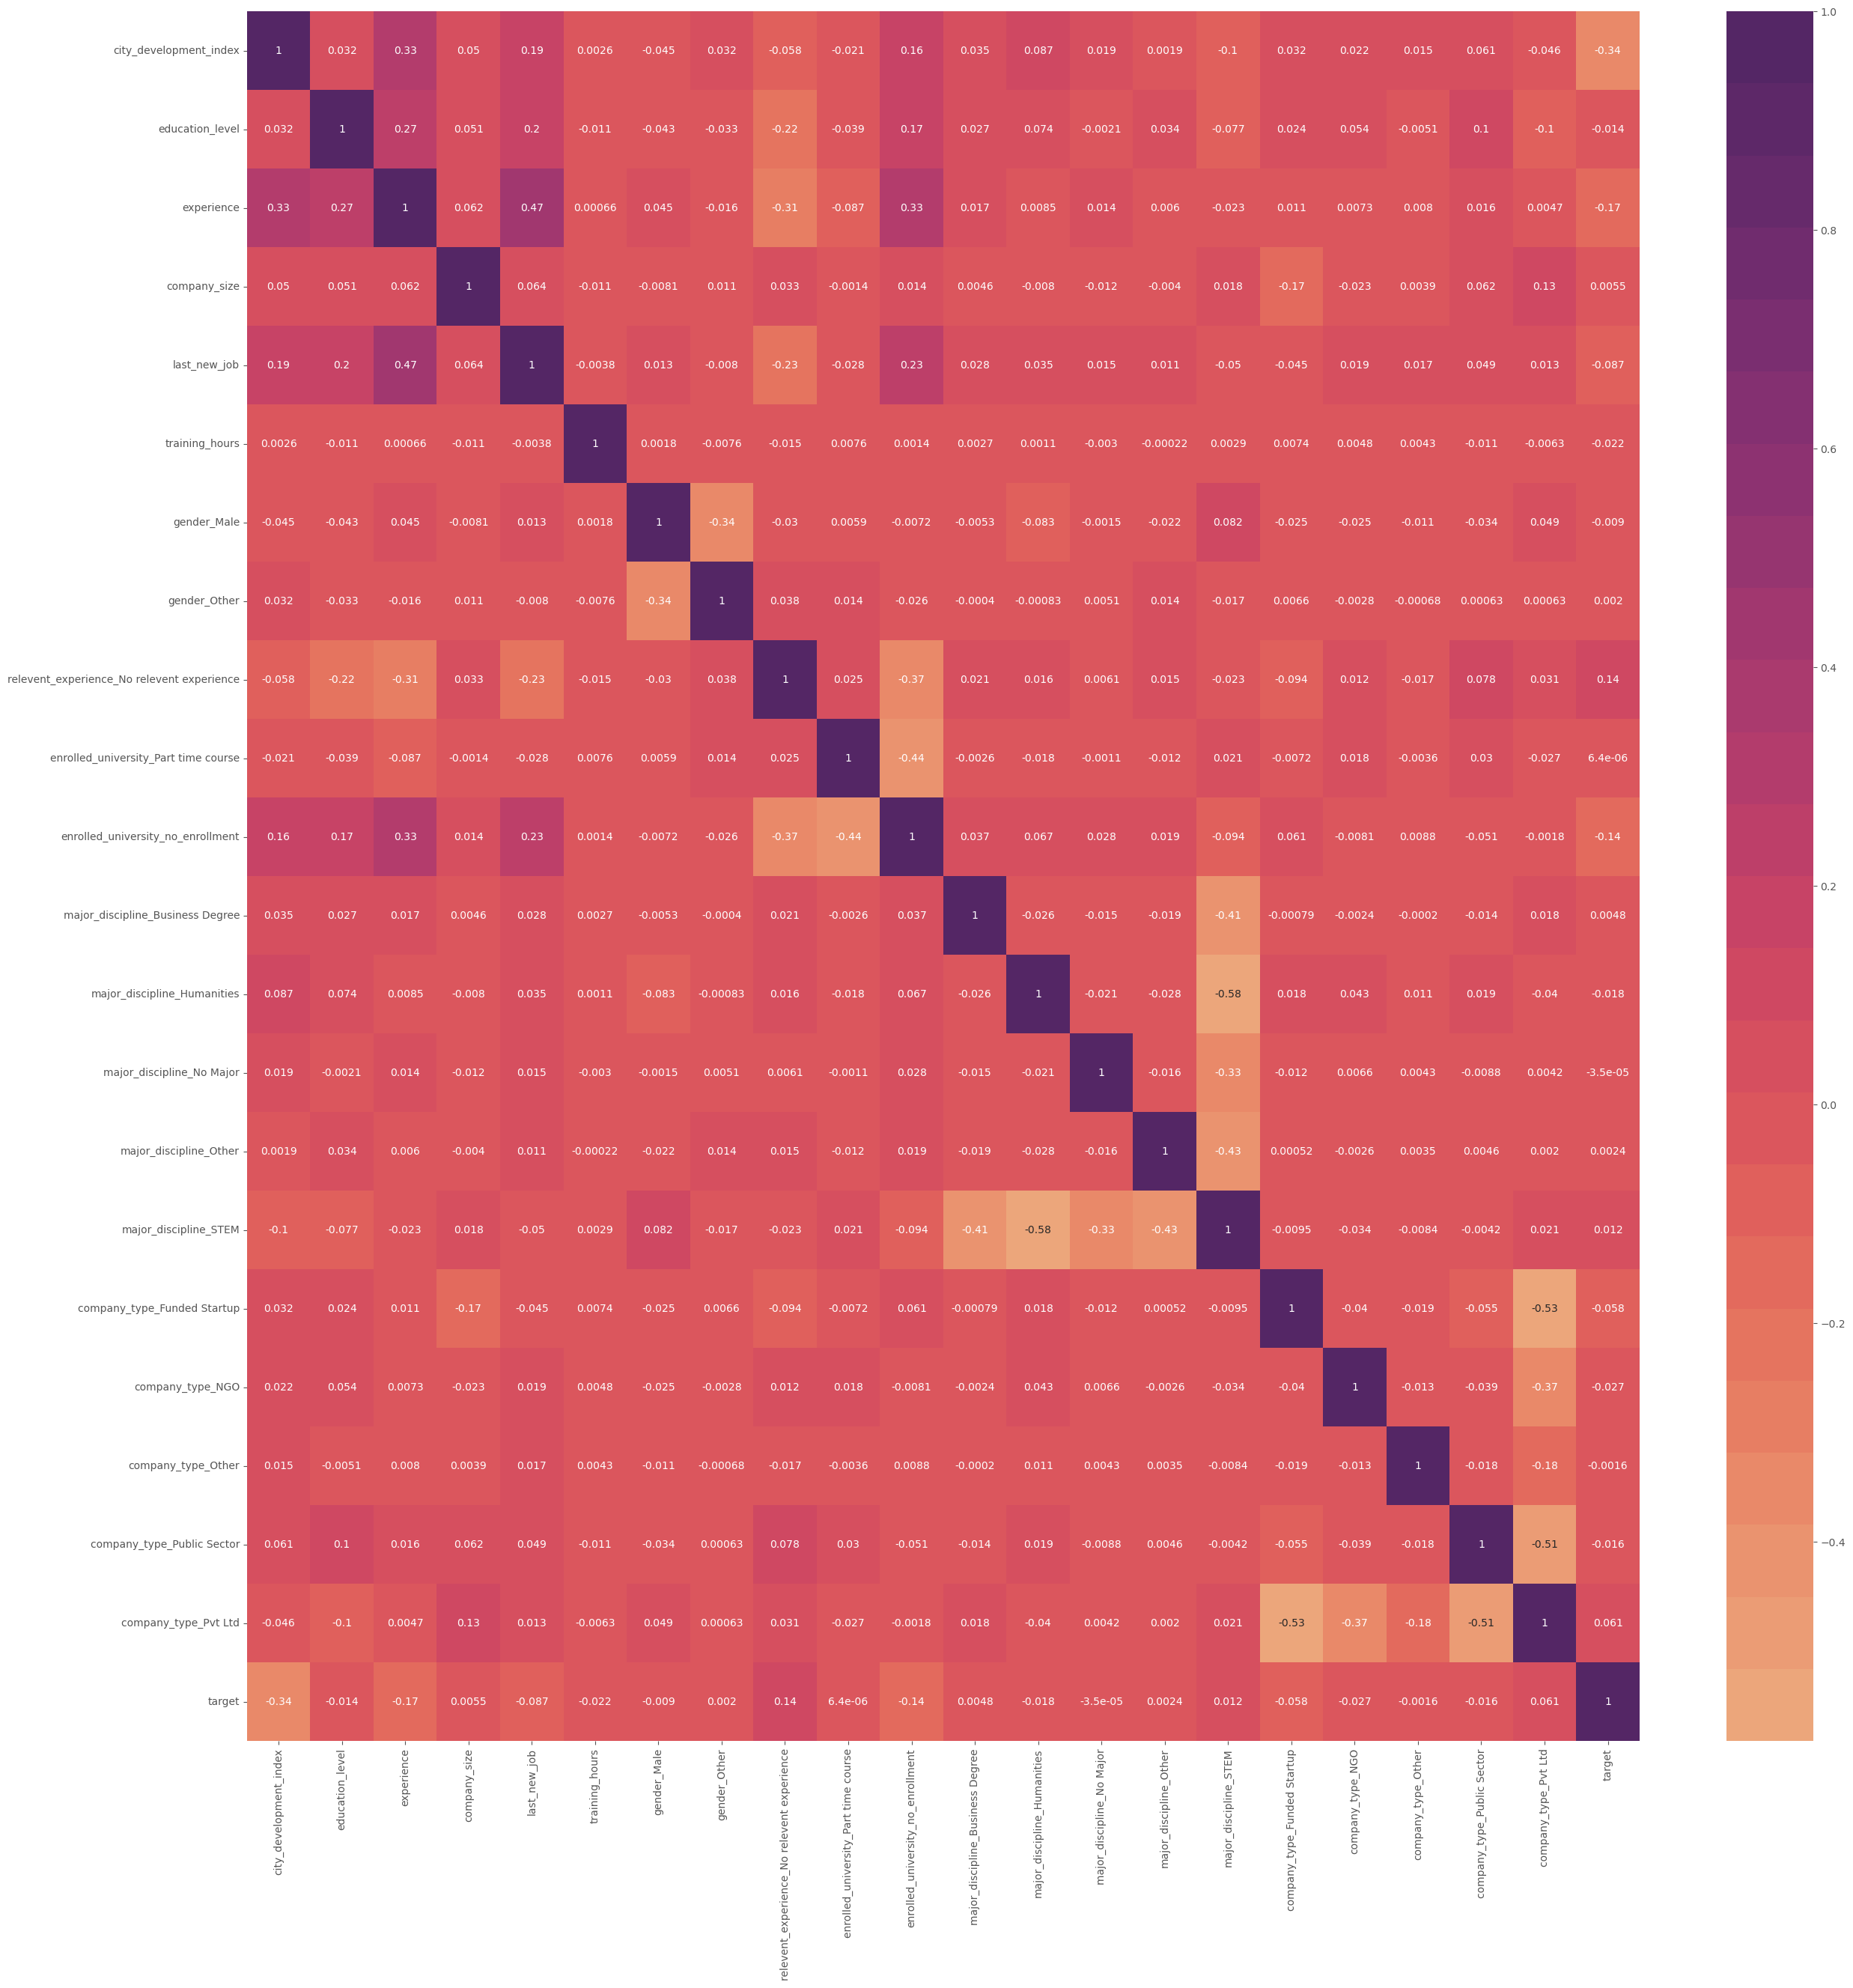

In [19]:
plt.figure(figsize=(30,30))
c=sns.color_palette("flare",24)
sns.heatmap(df_train_prep.corr(),annot=True,cmap=c)

In [20]:
np.abs(df_train_prep.corr()["target"]).sort_values(ascending=False)

target                                        1.000000
city_development_index                        0.336234
experience                                    0.169736
enrolled_university_no_enrollment             0.138353
relevent_experience_No relevent experience    0.135490
last_new_job                                  0.086669
company_type_Pvt Ltd                          0.061371
company_type_Funded Startup                   0.057745
company_type_NGO                              0.027257
training_hours                                0.022424
major_discipline_Humanities                   0.018123
company_type_Public Sector                    0.016371
education_level                               0.013937
major_discipline_STEM                         0.011837
gender_Male                                   0.009008
company_size                                  0.005495
major_discipline_Business Degree              0.004843
major_discipline_Other                        0.002445
gender_Oth

city_development_index、experience等が重要？

In [21]:
df_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18014 entries, 0 to 19157
Data columns (total 22 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   city_development_index                      18014 non-null  float32
 1   education_level                             18014 non-null  float32
 2   experience                                  18014 non-null  float32
 3   company_size                                18014 non-null  float32
 4   last_new_job                                18014 non-null  float32
 5   training_hours                              18014 non-null  float32
 6   gender_Male                                 18014 non-null  float32
 7   gender_Other                                18014 non-null  float32
 8   relevent_experience_No relevent experience  18014 non-null  float32
 9   enrolled_university_Part time course        18014 non-null  float32
 10  enrolled_u

In [22]:
from sklearn.model_selection import train_test_split

df_X = df_train_prep.drop(["target"],axis=1)
df_y = df_train_prep["target"]
#cudfに変換
cudf_X = cudf.from_pandas(df_X)
cudf_y = cudf.from_pandas(df_y)
#分割
X_train, X_valid, y_train, y_valid = train_test_split(cudf_X, cudf_y, train_size=0.8, random_state=2024)

### **4. モデルの学習＋ハイパーパラメータ最適化①**
- cuMLのRandomForestClassifierを使う
- まず適当にパラメータを設定、交差検証しを行う

In [25]:
from cuml.ensemble import RandomForestClassifier
import cuml
from cuml.metrics import roc_auc_score
from cuml.metrics.accuracy import accuracy_score
import time

from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from numpy import interp
import pickle

def cuML_CV_ROC(model, df_train_std:pd.DataFrame, df_train_y:pd.DataFrame, k:int=5, title="ROC", save_name=None):
    """交差検証し、ROC曲線をプロットする関数
    Args:
        model:cumlのモデル
        df_tran_std(pd.DataFrame):前処理済み学習データ
        df_train_y(pd.DataFrame):正解データ
        k:kfoldの回数
        title:図のタイトル
        save_name:モデル保存時のファイル名. Noneの場合、保存されない
    """
    best_score = 0
    fig4 = plt.figure(figsize=(10, 10))
    
    #平均のROC曲線、AUCを計算するための変数
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    mean_auc = 0
    #kfoldで分割、分割後のインデックスを取得
    cv = KFold(n_splits=k,shuffle=True).split(df_train_std, df_train_y)
    #1foldずつループで実行
    for idx, (train, test) in enumerate(cv):
        #インデックスからデータ取得、cudfに変換                                                                                      
        cudf_train_X, cudf_train_y = cudf.from_pandas(df_train_std.iloc[train]), cudf.from_pandas(df_train_y.iloc[train])
        cudf_test_X, cudf_test_y = cudf.from_pandas(df_train_std.iloc[test]), cudf.from_pandas(df_train_y.iloc[test])
        #学習                                                                                      
        model.fit(cudf_train_X, cudf_train_y)
        #テスト（評価）データの予測値（カテゴリ変数）を取得
        pred = model.predict(cudf_test_X)
        #テスト（評価）データの予測確率を取得                                                                                      
        y_pred_proba = model.predict_proba(cudf_test_X)
        #転職の確率を取得しnumpyに変換
        y_pred_proba_pandas = y_pred_proba.iloc[:,1:].to_numpy()                                                                                    
        
        #ROC曲線、AUCを取得、プロット
        fpr, tpr, thresholds = roc_curve(df_train_y.iloc[test],y_pred_proba_pandas,drop_intermediate=False)
        auc = roc_auc_score(cudf_test_y, pred)
        plt.plot(fpr, tpr, label='ROC fold %d (AUC= %0.3f)' % (idx+1, auc))
        
        #ベストスコアのモデルを保存
        if save_name is not None:
            if idx == 0:
                best_score = auc
                pickle.dump(model, open(f"best_{save_name}_model.pkl", "wb"))
            else:
                if auc > best_score:
                    best_score = auc
                    pickle.dump(model, open(f"best_{save_name}_model.pkl", "wb"))
    
        #平均を計算するためにroc曲線、aucを保存
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        mean_auc += auc

    #平均を計算
    mean_tpr = mean_tpr / k
    mean_auc = mean_auc / k
    mean_tpr[-1] = 1.0
    #プロット
    plt.plot(mean_fpr, mean_tpr,'k--', label='mean ROC (AUC= %0.3f)' % (mean_auc), lw=2)
    plt.plot([0,0,1],[0,1,1], linestyle=':',color='black', label='perfect ROC')
    plt.plot([0,1],[0,1],linestyle=':',color='black')
    plt.legend(loc='lower right')
    plt.title(title)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

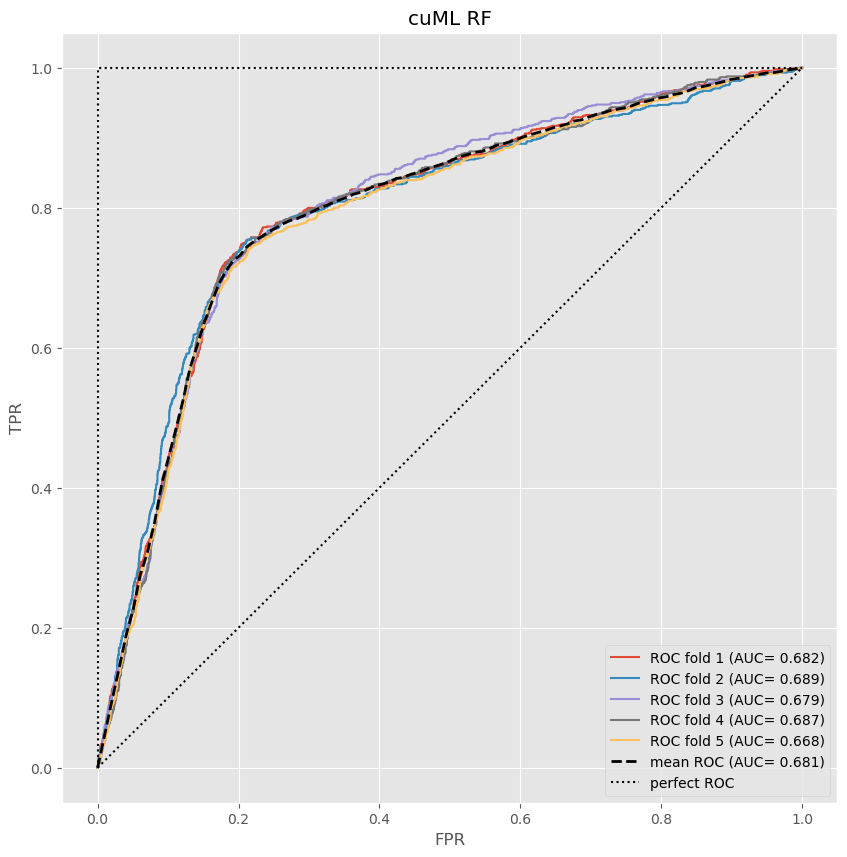

In [26]:
#交差検証
clf = RandomForestClassifier(n_estimators=300, max_depth=20,max_features="sqrt",n_streams=1,random_state=42)
cuML_CV_ROC(clf, df_X, df_y, title='cuML RF')

In [27]:
#ハイパーパラメータチューニング
def objective(trial):
    #パラメータの種類と範囲を指定
    n_estimators = trial.suggest_int("n_estimators",200,600)
    max_features = trial.suggest_categorical("max_features", ("sqrt", "log2"))
    max_depth=trial.suggest_int("max_depth",10,50)
    #モデルインスタンス作成
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,max_features=max_features,n_streams=1,random_state=42)
    #学習
    clf.fit(X_train, y_train)
    #予測
    pred = clf.predict(X_valid)
    #AUC
    auc = roc_auc_score(y_valid, pred)
    return auc

In [28]:
#時間計測
start_cuml = time.perf_counter()
#最適化実行
study = optuna.create_study(study_name="rapids_RF",direction="maximize")
study.optimize(objective,n_trials=100)
end_cuml = time.perf_counter()

#パラメータ保存
cuml_normal_best_n_estimators = study.best_params["n_estimators"]
cuml_normal_best_max_depth = study.best_params["max_depth"]
cuml_normal_best_max_features = study.best_params["max_features"]


print(f"Best ojective value: {study.best_value}")
print(f"Best parameter: {study.best_params}")

[I 2024-02-18 10:25:59,089] A new study created in memory with name: rapids_RF
[I 2024-02-18 10:26:01,451] Trial 0 finished with value: 0.6741756200790405 and parameters: {'n_estimators': 409, 'max_features': 'sqrt', 'max_depth': 44}. Best is trial 0 with value: 0.6741756200790405.
[I 2024-02-18 10:26:03,552] Trial 1 finished with value: 0.6761179566383362 and parameters: {'n_estimators': 391, 'max_features': 'sqrt', 'max_depth': 28}. Best is trial 1 with value: 0.6761179566383362.
[I 2024-02-18 10:26:06,449] Trial 2 finished with value: 0.674318790435791 and parameters: {'n_estimators': 489, 'max_features': 'sqrt', 'max_depth': 30}. Best is trial 1 with value: 0.6761179566383362.
[I 2024-02-18 10:26:08,055] Trial 3 finished with value: 0.6743647456169128 and parameters: {'n_estimators': 281, 'max_features': 'sqrt', 'max_depth': 40}. Best is trial 1 with value: 0.6761179566383362.
[I 2024-02-18 10:26:10,467] Trial 4 finished with value: 0.6745078563690186 and parameters: {'n_estimators

Best ojective value: 0.6820368766784668
Best parameter: {'n_estimators': 377, 'max_features': 'log2', 'max_depth': 17}


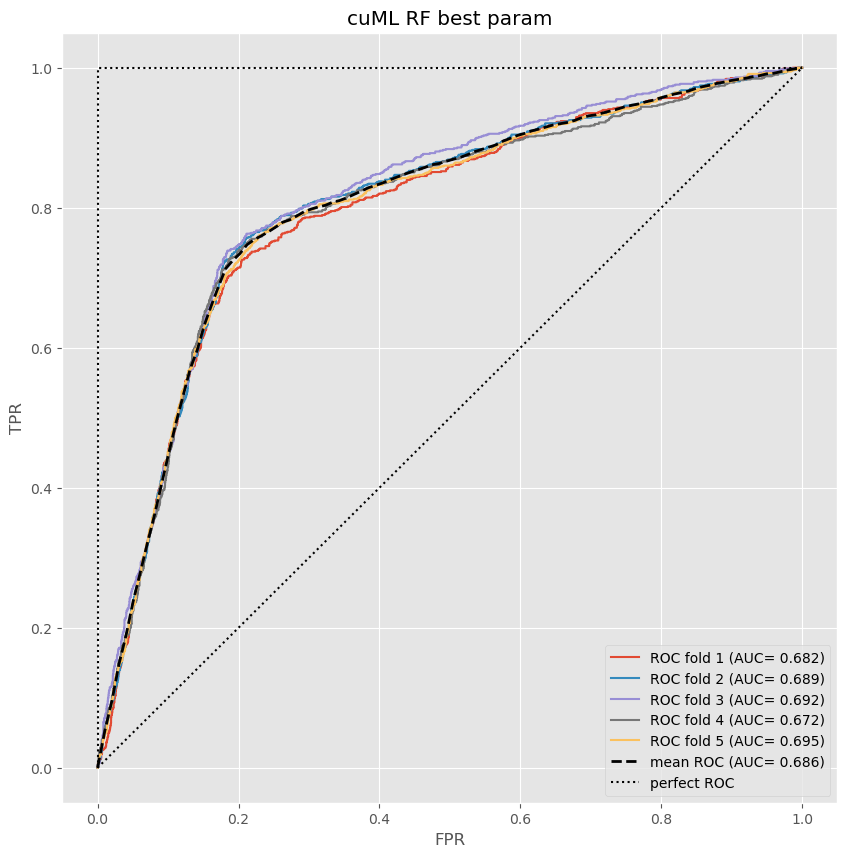

In [29]:
#ベストパラメータで交差検証
clf = RandomForestClassifier(n_estimators=cuml_normal_best_n_estimators, max_depth=cuml_normal_best_max_depth,max_features=cuml_normal_best_max_features,n_streams=1,random_state=42)
cuML_CV_ROC(clf, df_X, df_y, title='cuML RF best param')

### **5. インバランスデータへの対処**
- インバランスデータにSMOTE-NCで対処
- cuMLのNearestNeighborsと組み合わせて高速化

In [30]:
from imblearn.over_sampling import SMOTENC
from cuml.neighbors import NearestNeighbors

#インスタンス作成

#kNN
cuml_nn = NearestNeighbors(n_neighbors=5)
#SMOTE-NC
sm_cuml = SMOTENC(categorical_features=preprocess.categorical_cols,k_neighbors=cuml_nn, random_state=123)

#オーバーサンプリング実行
start_cuml_smotenc = time.perf_counter()
df_X_resampled, df_y_resampled = sm_cuml.fit_resample(df_X, df_y)
end_cuml_smotenc = time.perf_counter()

データの偏りを確認

<AxesSubplot:xlabel='target', ylabel='count'>

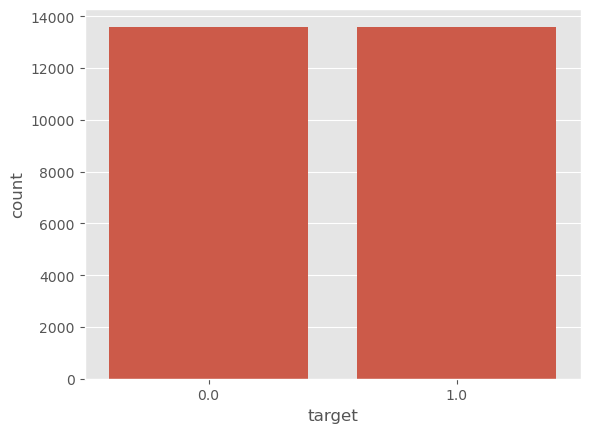

In [31]:
sns.countplot(x=df_y_resampled)

### **6. モデルの学習＋ハイパーパラメータ最適化②**

In [32]:
#cudfに変換
cudf_X_resampled = cudf.from_pandas(df_X_resampled)
cudf_y_resampled = cudf.from_pandas(df_y_resampled)
X_train_resampled, X_valid_resampled, y_train_resampled, y_valid_resampled = train_test_split(cudf_X_resampled, cudf_y_resampled, train_size=0.8, random_state=2024)

resampledデータでランダムフォレストを訓練

In [33]:
def objective(trial):
    #パラメータの種類と範囲を指定
    n_estimators = trial.suggest_int("n_estimators",200,600)
    max_features = trial.suggest_categorical("max_features", ("sqrt", "log2"))
    max_depth=trial.suggest_int("max_depth",10,50)
    #モデルインスタンス作成
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,max_features=max_features,n_streams=1,random_state=42)
    #学習
    clf.fit(X_train_resampled, y_train_resampled)
    #予測
    pred = clf.predict(X_valid_resampled)
    #AUC
    auc = roc_auc_score(y_valid_resampled, pred)
    return auc

#時間計測
start_cuml_resampled = time.perf_counter()
#最適化実行
study = optuna.create_study(study_name="rapids_RF_resampled",direction="maximize")
study.optimize(objective,n_trials=100)
end_cuml_resampled = time.perf_counter()

#パラメータを取得保存
cuml_smote_best_n_estimators = study.best_params["n_estimators"]
cuml_smote_best_max_depth = study.best_params["max_depth"]
cuml_smote_best_max_features = study.best_params["max_features"]

print(f"Best ojective value: {study.best_value}")
print(f"Best parameter: {study.best_params}")

[I 2024-02-18 10:31:16,571] A new study created in memory with name: rapids_RF_resampled
[I 2024-02-18 10:31:18,456] Trial 0 finished with value: 0.8283870220184326 and parameters: {'n_estimators': 333, 'max_features': 'log2', 'max_depth': 18}. Best is trial 0 with value: 0.8283870220184326.
[I 2024-02-18 10:31:19,647] Trial 1 finished with value: 0.8320262432098389 and parameters: {'n_estimators': 216, 'max_features': 'sqrt', 'max_depth': 21}. Best is trial 1 with value: 0.8320262432098389.
[I 2024-02-18 10:31:22,001] Trial 2 finished with value: 0.8005856275558472 and parameters: {'n_estimators': 495, 'max_features': 'sqrt', 'max_depth': 12}. Best is trial 1 with value: 0.8320262432098389.
[I 2024-02-18 10:31:25,479] Trial 3 finished with value: 0.835116982460022 and parameters: {'n_estimators': 548, 'max_features': 'sqrt', 'max_depth': 50}. Best is trial 3 with value: 0.835116982460022.
[I 2024-02-18 10:31:28,763] Trial 4 finished with value: 0.835123598575592 and parameters: {'n_es

Best ojective value: 0.8373110294342041
Best parameter: {'n_estimators': 233, 'max_features': 'sqrt', 'max_depth': 47}


AUC:0.69 → 0.84に上昇

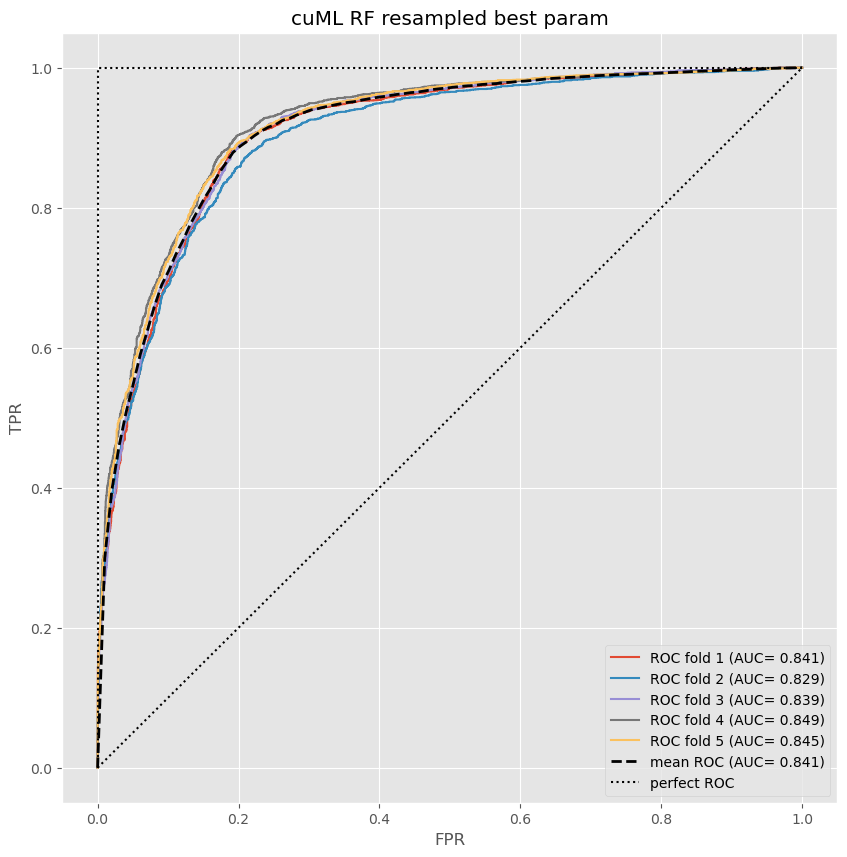

In [35]:
#モデルインスタンス作成
smote_clf = RandomForestClassifier(n_estimators=cuml_smote_best_n_estimators, max_depth=cuml_smote_best_max_depth,max_features=cuml_smote_best_max_features,n_streams=1,random_state=42)

#ベストパラメータで交差検証
cuML_CV_ROC(smote_clf, df_X_resampled, df_y_resampled, title='cuML RF resampled best param',save_name="cuml_resampled_data")

### **7. テストデータでの予測**

In [36]:
#テストデータで予測
df_test_prep = preprocess.fit(df_test,train=False)
df_test_X = df_test_prep.drop(["target"],axis=1)
df_test_y = df_test_prep["target"]

#cudfに変換
cudf_test_X = cudf.from_pandas(df_test_X)
cudf_test_y = cudf.from_pandas(df_test_y)
#交差検証時のベストモデルで予測
model = pickle.load(open("best_cuml_resampled_data_model.pkl", "rb"))
pred = model.predict(cudf_test_X)

test_auc = roc_auc_score(cudf_test_y, pred)

print(test_auc)

0.7426261305809021


### **Appendix**
### Scikit-Learnと比較

In [37]:
from sklearn.ensemble import RandomForestClassifier as sk_RF
from sklearn.metrics import accuracy_score, roc_auc_score 
from sklearn.metrics import roc_auc_score as sk_roc_auc_score

pd_X_train, pd_y_train, pd_X_valid, pd_y_valid = X_train.to_pandas(), y_train.to_pandas(), X_valid.to_pandas(), y_valid.to_pandas()

In [40]:
def sklearn_CV_ROC(model, df_train_std, df_train_y, k:int=5, title="ROC",save_name=None):
    """交差検証し、ROC曲線をプロットする関数
    Args:
        model:cumlのモデル
        df_tran_std(pd.DataFrame):前処理済み学習データ
        df_train_y(pd.DataFrame):正解データ
        k:kfoldの回数
        title:図のタイトル
        save_name:モデル保存時のファイル名. Noneの場合、保存されない
    """
    best_score = 0
    fig4 = plt.figure(figsize=(10, 10))
    
    #平均のROC曲線、AUCを計算するための変数
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    mean_auc = 0
    #kfoldで分割、分割後のインデックスを取得
    cv = KFold(n_splits=k,shuffle=True).split(df_train_std, df_train_y)
    for idx, (train, test) in enumerate(cv):
        #学習
        model.fit(df_train_std.iloc[train], df_train_y.iloc[train])
        #テスト（評価）データの予測値（カテゴリ変数）を取得
        y_pred_proba = model.predict_proba(df_train_std.iloc[test])
        
        #ROC曲線、AUCを取得、プロット
        fpr, tpr, thresholds = roc_curve(df_train_y.iloc[test], y_pred_proba[:,1],drop_intermediate=False)
        auc = sk_roc_auc_score(df_train_y.iloc[test], y_pred_proba[:,1])
        plt.plot(fpr, tpr, label='ROC fold %d (AUC= %0.3f)' % (idx+1, auc))
        
         #ベストスコアのモデルを保存
        if save_name is not None:
            if idx == 0:
                best_score = auc
                pickle.dump(model, open(f"best_{save_name}_model.pkl", "wb"))
            else:
                if auc > best_score:
                    best_score = auc
                    pickle.dump(model, open(f"best_{save_name}_model.pkl", "wb"))
    
        #平均を計算するためにroc曲線、aucを保存
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        mean_auc += auc

    #平均を計算
    mean_tpr = mean_tpr / k
    mean_auc = mean_auc / k
    mean_tpr[-1] = 1.0
    #プロット
    plt.plot(mean_fpr, mean_tpr,'k--', label='mean ROC (AUC= %0.3f)' % (mean_auc), lw=2)
    plt.plot([0,0,1],[0,1,1], linestyle=':',color='black', label='perfect ROC')
    plt.plot([0,1],[0,1],linestyle=':',color='black')
    plt.legend(loc='lower right')
    plt.title(title)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

In [41]:
def objective(trial):
    #パラメータの種類と範囲を指定
    n_estimators = trial.suggest_int("n_estimators",200,600)
    max_features = trial.suggest_categorical("max_features", ("sqrt", "log2"))
    max_depth=trial.suggest_int("max_depth",10,50)
    #モデルインスタンス作成
    clf = sk_RF(n_estimators=n_estimators, max_depth=max_depth,max_features=max_features,random_state=42)
    #学習
    clf.fit(pd_X_train, pd_y_train)
    #予測
    pred = clf.predict(pd_X_valid)
    #AUC
    auc = roc_auc_score(pd_y_valid, pred)
    return auc

#時間計測
start_skl = time.perf_counter()
#最適化実行
study = optuna.create_study(study_name="sklearn_RF",direction="maximize")
study.optimize(objective,n_trials=100)
end_skl = time.perf_counter()

#パラメータ保存
skl_normal_best_n_estimators = study.best_params["n_estimators"]
skl_normal_best_max_depth = study.best_params["max_depth"]
skl_normal_best_max_features = study.best_params["max_features"]

print(f"Best ojective value: {study.best_value}")
print(f"Best parameter: {study.best_params}")

[I 2024-02-18 10:42:12,205] A new study created in memory with name: sklearn_RF
[I 2024-02-18 10:42:16,092] Trial 0 finished with value: 0.6700345796412362 and parameters: {'n_estimators': 565, 'max_features': 'log2', 'max_depth': 13}. Best is trial 0 with value: 0.6700345796412362.
[I 2024-02-18 10:42:18,393] Trial 1 finished with value: 0.658226704885163 and parameters: {'n_estimators': 401, 'max_features': 'sqrt', 'max_depth': 11}. Best is trial 0 with value: 0.6700345796412362.
[I 2024-02-18 10:42:23,381] Trial 2 finished with value: 0.6629457137493512 and parameters: {'n_estimators': 521, 'max_features': 'log2', 'max_depth': 27}. Best is trial 0 with value: 0.6700345796412362.
[I 2024-02-18 10:42:26,665] Trial 3 finished with value: 0.6623570947422224 and parameters: {'n_estimators': 541, 'max_features': 'sqrt', 'max_depth': 12}. Best is trial 0 with value: 0.6700345796412362.
[I 2024-02-18 10:42:29,200] Trial 4 finished with value: 0.6689159077392455 and parameters: {'n_estimator

Best ojective value: 0.6816020769870279
Best parameter: {'n_estimators': 587, 'max_features': 'sqrt', 'max_depth': 15}


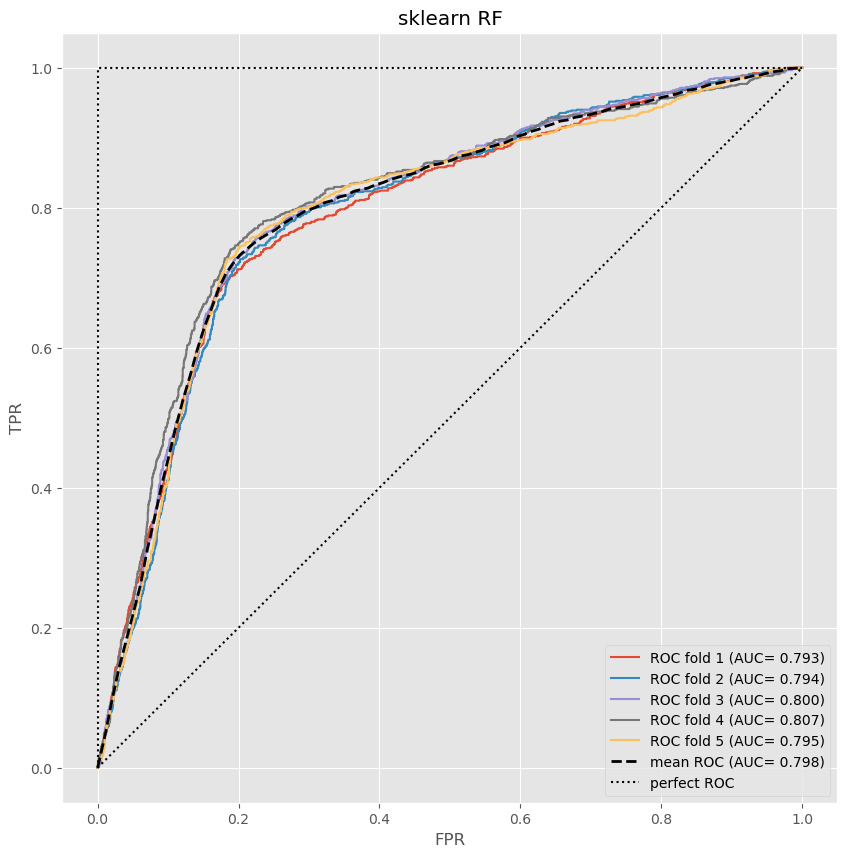

In [43]:
#モデルインスタンス作成
clf = sk_RF(n_estimators=skl_normal_best_n_estimators, max_depth=skl_normal_best_max_depth,max_features=skl_normal_best_max_features,random_state=42)
#ベストパラメータで交差検証
sklearn_CV_ROC(clf, df_X, df_y, title='sklearn RF')

cuMLなしSMOTE-NCを試す

In [44]:
#インスタンス作成
sm = SMOTENC(categorical_features=preprocess.categorical_cols,random_state=123)

#オーバーサンプリング実行
start_smotenc = time.perf_counter()
df_X_resampled, df_y_resampled = sm.fit_resample(df_X, df_y)
end_smotenc = time.perf_counter()

<AxesSubplot:xlabel='target', ylabel='count'>

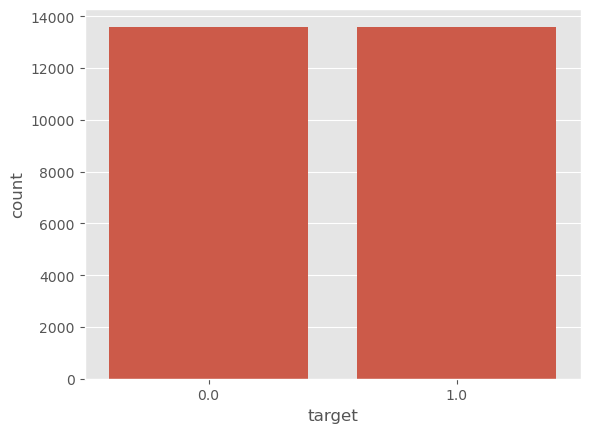

In [45]:
sns.countplot(x=df_y_resampled)

resampledデータでscikit-learnのランダムフォレストを訓練

In [46]:
pd_X_train_resampled, pd_y_train_resampled, pd_X_valid_resampled, pd_y_valid_resampled = X_train_resampled.to_pandas(), y_train_resampled.to_pandas(), X_valid_resampled.to_pandas(), y_valid_resampled.to_pandas()

In [47]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators",200,600)
    max_features = trial.suggest_categorical("max_features", ("sqrt", "log2"))
    max_depth=trial.suggest_int("max_depth",10,50)
    clf = sk_RF(n_estimators=n_estimators, max_depth=max_depth,max_features=max_features,random_state=42)
    clf.fit(pd_X_train_resampled, pd_y_train_resampled)
    pred = clf.predict(pd_X_valid_resampled)
    auc = roc_auc_score(pd_y_valid_resampled, pred)
    return auc

start_skl_resampled = time.perf_counter()
study = optuna.create_study(study_name="sklearn_RF_resampled",direction="maximize")
study.optimize(objective,n_trials=100)
end_skl_resampled = time.perf_counter()

#パラメータを取得保存
skl_smote_best_n_estimators = study.best_params["n_estimators"]
skl_smote_best_max_depth = study.best_params["max_depth"]
skl_smote_best_max_features = study.best_params["max_features"]

print(f"Best ojective value: {study.best_value}")
print(f"Best parameter: {study.best_params}")

[I 2024-02-18 10:50:49,663] A new study created in memory with name: sklearn_RF_resampled
[I 2024-02-18 10:50:54,613] Trial 0 finished with value: 0.8518863252581672 and parameters: {'n_estimators': 277, 'max_features': 'log2', 'max_depth': 27}. Best is trial 0 with value: 0.8518863252581672.
[I 2024-02-18 10:50:59,431] Trial 1 finished with value: 0.8404946309887208 and parameters: {'n_estimators': 363, 'max_features': 'log2', 'max_depth': 18}. Best is trial 0 with value: 0.8518863252581672.
[I 2024-02-18 10:51:05,443] Trial 2 finished with value: 0.8524414929315236 and parameters: {'n_estimators': 372, 'max_features': 'log2', 'max_depth': 27}. Best is trial 2 with value: 0.8524414929315236.
[I 2024-02-18 10:51:08,932] Trial 3 finished with value: 0.8538186551492716 and parameters: {'n_estimators': 213, 'max_features': 'log2', 'max_depth': 35}. Best is trial 3 with value: 0.8538186551492716.
[I 2024-02-18 10:51:13,009] Trial 4 finished with value: 0.8509351118183195 and parameters: {'

Best ojective value: 0.8549091002576259
Best parameter: {'n_estimators': 322, 'max_features': 'log2', 'max_depth': 32}


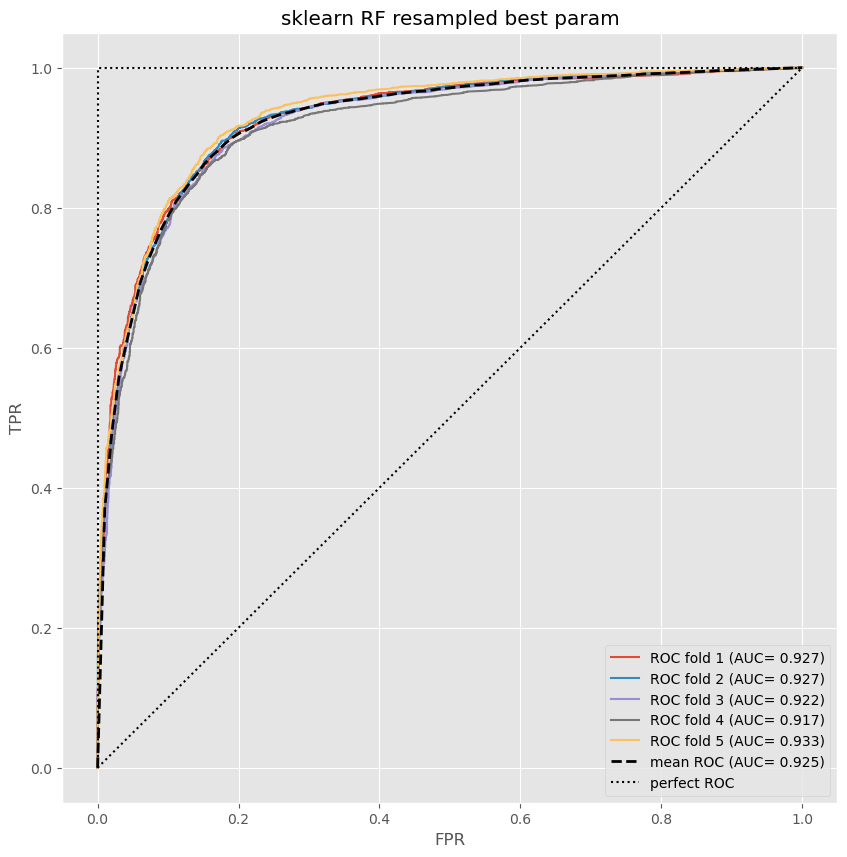

In [49]:
#モデルインスタンス作成
smote_clf = sk_RF(n_estimators=skl_smote_best_n_estimators, max_depth=skl_smote_best_max_depth,max_features=skl_smote_best_max_features,random_state=42)
#ベストパラメータで交差検証
sklearn_CV_ROC(smote_clf, df_X_resampled, df_y_resampled, title='sklearn RF resampled best param')

### 実行時間を比較

In [50]:
#実行時間計算
time_cuml_smote = end_cuml_smotenc-start_cuml_smotenc
time_skl_smote = end_smotenc-start_smotenc

time_cuml = end_cuml-start_cuml 
time_skl = end_skl-start_skl

time_cuml_resampled = end_cuml_resampled-start_cuml_resampled 
time_skl_resampled = end_skl_resampled-start_skl_resampled
data = [time_cuml_smote,time_skl_smote,time_cuml,time_skl,time_cuml_resampled,time_skl_resampled]
#データフレーム作成
df_time = pd.DataFrame({"time":data},index=["cuML+SMOTE-NC","SMOTE-NC","cuML","sklearn","cuML(resampled)","sklearn(resampled)"]).T

In [51]:
df_time

,cuML+SMOTE-NC,SMOTE-NC,cuML,sklearn,cuML(resampled),sklearn(resampled)
time,2.363255,3.394488,186.370443,351.795336,183.981337,522.764416


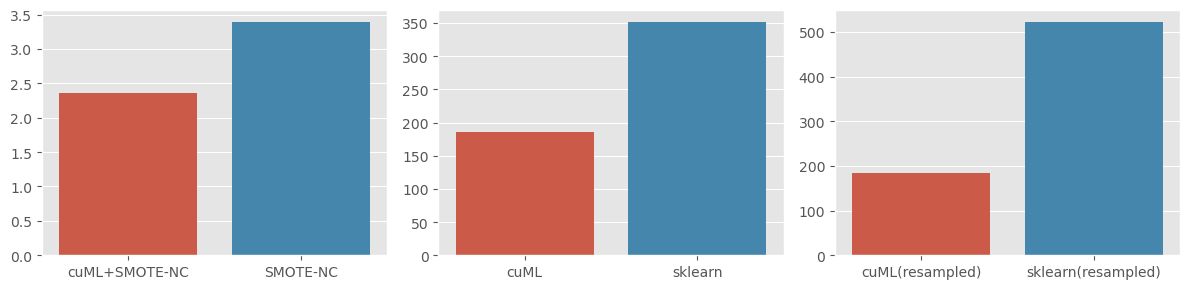

In [52]:
fig, ax = plt.subplots(1,3,figsize=(12,3),tight_layout=True)
ax = ax.flatten()
for i in range(2,6+1,2):
    sns.barplot(df_time.iloc[:,i-2:i],ax=ax[i//2-1])